## FBCCA and Extended FBCCA for SSVEP signals classification

In [ ]:
# Imports:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.linalg as linalg
import scipy.stats as stats
import scipy.fftpack as fftpack
import scipy.io as sio
import scipy.io.wavfile as wavfile

from sklearn.cross_decomposition import CCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

from scipy.signal import butter, lfilter


## Description of the task:

To implement the FBCCA method on python, follow these steps:

- Define the parameters for the FBCCA method, such as the number of harmonics (Nh), the weight vector (w), the number of sub-bands (N), and the filter bank design (M1, M2, or M3): (M1: sub-bands with equally spaced bandwidths; M2: sub-bands corresponding to individual harmonic frequency bands; M3: sub-bands covering multiple harmonic frequency bands.

- Define the reference signals for each stimulation frequency using function 5 (generate_ref_signgal). The reference signals should have a shape of (n_samples, Nh * 2), where n_samples is the number of samples in your signal window.

- Define a function to perform CCA between two multi-dimensional variables. Use the CCA module from sklearn.cross_decomposition.

- Define a function to perform filter bank analysis on your SSVEP signals using a zero-phase Chebyshev Type I IIR filter. You can use the filtfilt() function from scipy.signal to apply the filter. The filter bank analysis should output a set of sub-band signals, each with a shape of (n_samples, n_channels), where n_channels is the number of channels in your signals.

- For each sub-band signal, apply the CCA function to calculate the correlation vector between the sub-band signal and the reference signals for each stimulation frequency using equation (5). The correlation vector should have a shape of (1, Nh * 2).

- For each stimulation frequency, calculate the feature vector by using a weighted sum of squares of the correlation values corresponding to all sub-band components using equation (6). The feature vector should have a shape of (1, N).

- Compare the feature vector with a threshold value to determine the target frequency. The threshold value can be optimized by a grid search method. If the feature vector exceeds the threshold value, then the target frequency is the frequency corresponding to the reference signal. If not, then the target frequency is unknown.
Source: "Filter bank canonical correlation analysis for implementing a high-speed" by Xiaogang Chen, et al. 2015
SSVEP-based brain-computer interface
https://pubmed.ncbi.nlm.nih.gov/26035476/


In [28]:
"""Utility functions"""

# Function 5: generate_ref_signal
# Input: Freq_phase_path, SSVEP frecuencies (targets), number of samples, number of harmonics, sampling frequency
# Output: reference signal
def generate_ref_signal(Freq_phase_path: str, freqs: list, N: int, n_harmonics: int, fs: int) -> np.ndarray:
    data = sio.loadmat(Freq_phase_path)
    index_freqs = data['freqs'].round(1).reshape(-1).tolist()
    phases = data['phases'].reshape(-1)  # phases

        # Reference signal
    ref_signal = np.zeros((N, len(freqs), n_harmonics * 2,))
    # For each frequency
    f = 0
    for frequency in freqs:
        phase = phases[index_freqs.index(round(frequency, 1))]
        print(f"Phase: {phase} for Freq: {frequency}")
        
        # For each harmonic
        for i in range(0, n_harmonics * 2, 2):
            # Sinusoid
            ref_signal[:, f, i] = np.sin(2 * np.pi * frequency * (i + 1) * np.arange(N) / fs + phase)
            # Cosinusoid
            ref_signal[:, f, i + 1] = np.cos(2 * np.pi * frequency * (i + 1) * np.arange(N) / fs + phase)
       
        f+=1

    return ref_signal

# Function 1: filter_bank_analysis
# Input: signal, sampling frequency, number of sub-bands, filter bank design
# Output: sub-band signals
def filter_bank_analysis(in_signal, fs, n_subbands, filter_bank_design):
    epsilon = 0.0000001
    # Number of channels
    n_channels = in_signal.shape[1]
    # Number of samples
    n_samples = in_signal.shape[0]
    # Filter bank design
    if filter_bank_design == 'M1':
        # Sub-band signals
        subband_signals = np.zeros((n_samples, n_channels, n_subbands))
        # For each sub-band
        for i in range(0, n_subbands):
            # Sub-band filter
            b, a = signal.cheby1(4, 0.1, [epsilon + 2 * np.pi * (i) / n_subbands, 2 * np.pi * (i + 1) / n_subbands], 'bandpass', fs=fs)
            # Filtered signal
            subband_signals[:, :, i] = signal.filtfilt(b, a, in_signal, axis=0)
    elif filter_bank_design == 'M2':
        # Sub-band signals
        subband_signals = np.zeros((n_samples, n_channels, n_subbands))
        # For each sub-band
        for i in range(n_subbands):
            # Sub-band filter
            b, a = signal.cheby1(4, 0.1, [epsilon + 2 * np.pi * (i + 1) / n_subbands, 2 * np.pi * (i + 1) / n_subbands], 'bandpass', fs=fs)
            # Q: What is cheby1?
            # A: Chebyshev Type I filter
            # Filtered signal
            subband_signals[:, :, i] = signal.filtfilt(b, a, in_signal, axis=0)
    elif filter_bank_design == 'M3':
        # Sub-band signals
        subband_signals = np.zeros((n_samples, n_channels, n_subbands))
        # For each sub-band
        for i in range(n_subbands):
            # Sub-band filter
            b, a = signal.cheby1(4, 0.1, [epsilon + 2 * np.pi * (i) / n_subbands, 2 * np.pi * (i + 2) / n_subbands], 'bandpass', fs=fs)
            # Filtered signal
            subband_signals[:, :, i] = signal.filtfilt(b, a, in_signal, axis=0)

    return subband_signals

#  - Define a function to perform CCA between two multi-dimensional variables. Use the CCA module from sklearn.cross_decomposition.
# Function 2: cca
# Input: signal 1, signal 2
# Output: correlation vector
def cca(signal1, signal2):
    # Canonical correlation analysis
    cca = CCA()
    
    # Fit the model with signal 1 and signal 2
    cca.fit(signal1, signal2)

    # Correlation vector
    correlation_vector = cca.transform(signal1, signal2)

    return correlation_vector

# Function 3: feature_extraction
# Input: sub-band signals, reference signals, weight vector
# Output: feature vector
def feature_extraction(subband_signals, ref_signals, w):
    # Number of sub-band signals
    n_subbands = subband_signals.shape[2]
    # Number of reference signals
    n_refs = ref_signals.shape[1]
    # Feature vector
    feature_vector = np.zeros((1, n_subbands))
    # For each sub-band signal
    for i in range(n_subbands):
        # Correlation vector
        correlation_vector = cca(subband_signals[:, :, i], ref_signals) # shape: (1000, 6)
        # Weighted sum of squares of the correlation values
        feature_vector[0, i] = np.sum(np.dot(correlation_vector, w) ** 2)

    return feature_vector

# Function 4: fbcca
# Input: signal, sampling frequency, number of harmonics, number of sub-bands, filter bank design, weight vector, reference signals
# Output: target frequency
def fbcca(in_signal, fs, n_harmonics, n_subbands, filter_bank_design, w, ref_signals):
    # Number of channels
    n_channels = in_signal.shape[1]
    # Number of samples
    n_samples = in_signal.shape[0]
    # Sub-band signals
    subband_signals = filter_bank_analysis(in_signal, fs, n_subbands, filter_bank_design)
    # Feature vector
    feature_vector = feature_extraction(subband_signals, ref_signals, w)
    # Target frequency
    print(feature_vector)
    target_frequency = np.argmax(feature_vector) + 1

    return target_frequency



The frequency and phase values are used to generate the SSVEP stimuli. The stimuli are generated by the following equation:

$$
x(t) = sin(2\pi f t + \phi)
$$

where $f$ is the frequency and $\phi$ is the phase value.

In [19]:
def main():
    # SSVEP target frequencies
    frequencies = [8, 10, 12]
    # Number of samples
    N = 1000
    # Sampling frequency
    fs = 250
    # Number of harmonics
    n_harmonics = 3
    # Number of sub-bands
    n_subbands = 8
    # Filter bank design
    filter_bank_design = 'M1'
    # Weight vector
    w = np.ones((2, n_harmonics * 2))
    # Reference signals
    ref_signals = generate_ref_signal('data/raw/Freq_Phase.mat', frequencies, N, n_harmonics, fs)
    # Signal
    in_signal = np.load('data/final/1/S1_0.npy') # Shape: (1000, 3)

    # Target frequency
    target_frequency = fbcca(in_signal, fs, n_harmonics, n_subbands, filter_bank_design, w, ref_signals)
    print(target_frequency)

if __name__ == "__main__":
    main()    

[[12016.08306259 24742.30112099 14768.41522839 21981.28767705
  18337.30085562 12296.81142763 12447.65680592 21747.68467673]]
2


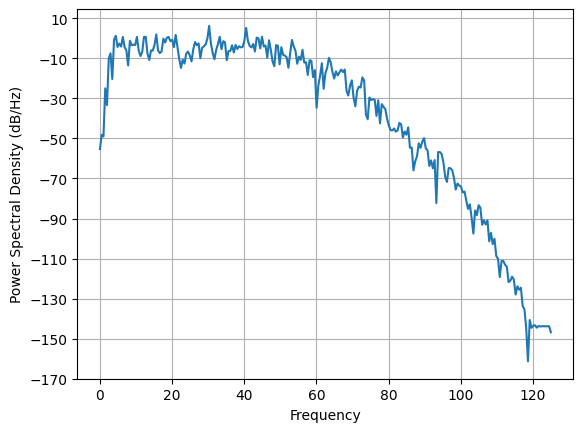

In [46]:
in_signal = np.load('data/final/1/S10_0.npy') # Shape: (1000, 3)

# plot the power spectrum
plt.figure()
plt.psd(in_signal[:, 0], 512, 250)
plt.show()
# 